# Text classification (sentiment analysis)
Task: Predict sentiment of Amazon reviews
Dataset: Amazon US Customer Reviews Dataset

## 1. Loading dataset & basic preprocessing
- removal of reviews shorter than 5 characters
- mapping from 1-5 -> 0,1,2
- subsampling - without replacement, random state 42, 80 000 rows
- stratified train-test split -> preserves ratio of target class in order to represent the distrubution correctly
- removed english stopwords
- removed non alphanumerical characters

Dataset is a subset of https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset and concerns only one tsv file amazon_reviews_us_Major_Appliances_v1_00.tsv

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from IPython.display import display
import re
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
# from google.colab import drive


In [2]:
tf.__version__

'2.15.0'

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
drive.mount('/content/drive')
dir="/content/drive/MyDrive/"
df = pd.read_csv(f'{dir}amazon_reviews_us_Major_Appliances_v1_00.tsv', sep='\t', on_bad_lines='skip')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df.shape

(96834, 15)

In [4]:
# remove nas and duplicate reviews
df.dropna(axis=0, subset=['review_body'], inplace=True)
df.drop_duplicates(subset=['review_body'], inplace=True)

In [7]:
df.shape

(93446, 15)

In [5]:
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words("english") # removes stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def remove_tags(review):
    return re.sub(pattern='<.*?>', string=review , repl=' ')

def keep_alnum(review):
    return re.sub(pattern='[^A-Za-z\d\s:]', string=review, repl=' ')

def strip_spaces(review):
    return re.sub(pattern='[\s]{2,}', string=review, repl=' ')

def lowercase(review):
    return review.lower()

def remove_stopwords(review):
    review_list = review.split()
    return " ".join([word for word in review_list if word not in stopword_list])

In [7]:
df['review_body'] = df['review_body'].apply(remove_tags)        # remove html tags
df['review_body'] = df['review_body'].apply(keep_alnum)         # remove sub unicode char
df['review_body'] = df['review_body'].apply(strip_spaces)       # strip all unnecessary whitespaces
df['review_body'] = df['review_body'].apply(lowercase)          # put everything into lowercase
df['review_body'] = df['review_body'].apply(remove_stopwords)   # put everything into lowercase
df = df[df['review_body'].str.len() > 5]                        # keep only reviews longer than 5 characters

In [11]:
df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,16199106,R203HPW78Z7N4K,B0067WNSZY,633038551,"FGGF3032MW Gallery Series 30"" Wide Freestandin...",Major Appliances,5,0,0,N,Y,"If you need a new stove, this is a winner.",great stove wonderful replacement sort antique...,2015-08-31
1,US,16374060,R2EAIGVLEALSP3,B002QSXK60,811766671,Best Hand Clothes Wringer,Major Appliances,5,1,1,N,Y,Five Stars,worked great,2015-08-31
2,US,15322085,R1K1CD73HHLILA,B00EC452R6,345562728,Supco SET184 Thermal Cutoff Kit,Major Appliances,5,0,0,N,Y,Fast Shipping,part exactly needed saved purchasing,2015-08-31
3,US,32004835,R2KZBMOFRMYOPO,B00MVVIF2G,563052763,Midea WHS-160RB1 Compact Single Reversible Doo...,Major Appliances,5,1,1,N,Y,Five Stars,love refrigerator keeps everything cold recommend,2015-08-31
4,US,25414497,R6BIZOZY6UD01,B00IY7BNUW,874236579,Avalon Bay Portable Ice Maker,Major Appliances,5,0,0,N,Y,Five Stars,running store ice works perfectly,2015-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96829,US,37431087,R3CYIDM3UEY5PA,B00005O64S,222987122,Haier HDT18PA Space Saver Compact Countertop D...,Major Appliances,4,37,43,N,N,Pretty good dishwasher for small apartment,pretty good dishwasher price good job cleaning...,2002-07-14
96830,US,44686434,R1PLFLGSA6N9WU,B00005O64T,802734810,Haier America HSE02-WNAWW 1.8-Cubic-Foot Capac...,Major Appliances,1,33,39,N,N,Does not last long,bought office extremely dissatisfied stopped w...,2002-06-03
96831,US,36739731,RBPARLMOY6ZU5,B00005O64S,222987122,Haier HDT18PA Space Saver Compact Countertop D...,Major Appliances,5,6,45,N,N,Rave review for space saver,saw small dishwasher thought wonderful idea sm...,2002-05-05
96832,US,50744080,RSS5TDZOGUEB6,B00004SACT,344802997,Sanyo Two-Door 2.9 Cubic Foot Refrigerator,Major Appliances,4,71,71,N,N,Sanyo compact refrigerator,probably best small refrigerator market true f...,2000-09-29


In [8]:
df.loc[df['star_rating'] < 3, 'sentiment'] = 0
df.loc[df['star_rating'] == 3, 'sentiment'] = 1
df.loc[df['star_rating'] > 3, 'sentiment'] = 2
df['sentiment'] = df['sentiment'].astype('int')
df.drop('star_rating', axis=1, inplace=True)
df = resample(df, n_samples=80000, random_state=42, replace=False)

<ipython-input-8-cc3c5e4fce76>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['star_rating'] < 3, 'sentiment'] = 0
<ipython-input-8-cc3c5e4fce76>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].astype('int')
<ipython-input-8-cc3c5e4fce76>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [13]:
df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
71963,US,23022807,R3IZQ5QBR0C7B7,B0039V7JFG,184993957,LG 3.6 CF FRONT LOAD WASHER DRYER COMBO,Major Appliances,5,14,N,N,lg small washer/dryer set,usually rate things hate exactly feel small lg...,2013-04-06,0
15508,US,21831333,R2LGGHUB944XMT,B00EJPHJVK,516641616,Fantech Lint Trap for Dryer Booster - DBLT4W (...,Major Appliances,0,0,N,Y,very hard to open must be securely mounted no ...,hard open must securely mounted provisions,2015-04-16,1
3110,US,11941986,R21U3YZPS3MBXG,B00HH2YZT6,73366442,Samsung RF32FMQDBSR 4-Door Refrigerator with C...,Major Appliances,6,6,N,N,15 month useful life - this should be disconti...,15 months stopped working threw groceries call...,2015-08-07,0
88804,US,46476694,R2JZ0YSJ5QEZX4,B001VKY8GU,232040651,Koolatron Coca Cola Personal Cube Fridge,Major Appliances,0,0,N,N,Unexpectedly Awesome,silver version tiny cooler fridge company chri...,2011-06-28,2
18295,US,48338607,R2QENB1J5LBM14,B00MZH0OPC,394118467,( 2 PACK ) 3392519 - DRYER THERMAL FUSE for Wh...,Major Appliances,0,0,N,Y,Perfect,exactly needed get dryer back,2015-03-22,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62973,US,31634986,R173X6QPB1N8SY,B004HXDLJ8,693470227,Whynter BWR-18SD 18 Bottle Built-In Wine Refri...,Major Appliances,11,12,N,Y,Very Happy,purchased replace space 12 34 garbage compacto...,2013-09-28,2
45682,US,52949439,R4YB9KY26NLPP,B003GFAY52,647457047,Broan 30W in. QP2 Under Cabinet Range Hood,Major Appliances,9,9,N,Y,Up until it quit working I though I had made a...,bought item professionally installed middle ap...,2014-07-07,0
84940,US,42829199,R1W9QEUT7MIYGD,B004WP4BAO,480751909,Samsung DV5451AGW,Major Appliances,4,4,N,N,Does NOT dry clothes. So not much of a dryer.,purchased nice looking supposedly good name br...,2012-02-18,0
1873,US,19293947,R12LFU2ZVPAZSS,B0125S2K0M,504103070,Avalon Top Loading Water Cooler Dispenser - Ho...,Major Appliances,144,156,N,N,Avalon water dispenser beat my many previous w...,videoid:8829556f67d2453e377e6459465db27e first...,2015-08-16,2


## 2. Final dataset
- 80 000 instances
- NEGATIVE 21 334
- NEUTRAL 5 674
- POSITIVE 52 992
- **Quite imbalanced -> experiment with class weights**
- 90:10 train:test split

Vectorization with length of vectors 128 and dictionary size 8000. Didn't use one-hot encoding.

In [14]:
df['sentiment'].value_counts()

sentiment
2    52992
0    21334
1     5674
Name: count, dtype: int64

In [9]:
# Train-test split
df_multimodal = df
df = df[['review_body', 'sentiment']]

X_train, X_test, y_train, y_test = train_test_split(
    df['review_body'], df['sentiment'], random_state=42, test_size=0.1, stratify=df['sentiment']
)
#Train-val split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)


In [16]:
y_train.value_counts()

sentiment
2    42924
0    17280
1     4596
Name: count, dtype: int64

In [17]:
y_test.value_counts()

sentiment
2    5299
0    2134
1     567
Name: count, dtype: int64

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [11]:
max_length = 128
max_tokens = 8000

text_vectorization = TextVectorization(
    ngrams=1,
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length
)
text_only_train_ds = train_dataset.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

In [20]:
vocab = np.array(text_vectorization.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'one', 'water', 'would', 'great', 'like', 'get',
       'unit', 'ice', 'time', 'use', 'machine', 'well', 'good', 'washer',
       'product', 'works', 'new', '2'], dtype='<U15')

In [12]:
def vectorize_text(text, label):
    return text_vectorization(text), label

train_ds = (train_dataset.map(vectorize_text).cache()
            .shuffle(10000)
            .batch(32)
            .prefetch(buffer_size=tf.data.AUTOTUNE))

val_ds = (validation_dataset.map(vectorize_text)
          .cache()
          .batch(32)
          .prefetch(buffer_size=tf.data.AUTOTUNE))

test_ds = (test_dataset.map(vectorize_text)
           .cache()
           .batch(32)
           .prefetch(buffer_size=tf.data.AUTOTUNE))


In [22]:
for inputs, targets in train_ds:
    print("inputs data type",inputs.dtype)
    print("inputs shape",inputs.shape)
    print("targets data type",targets.dtype)
    print("targets shape",targets.shape)
    print("inputs[0]", inputs)
    print("targets[0]", targets)
    break

inputs data type <dtype: 'int64'>
inputs shape (32, 128)
targets data type <dtype: 'int64'>
targets shape (32,)
inputs[0] tf.Tensor(
[[   2  643 1335 ...    0    0    0]
 [ 264  130  895 ...    0    0    0]
 [ 243  697  278 ...    0    0    0]
 ...
 [2596 2064  150 ...    0    0    0]
 [  27  370   27 ...    0    0    0]
 [4529  337  321 ...    0    0    0]], shape=(32, 128), dtype=int64)
targets[0] tf.Tensor([0 2 0 2 0 2 1 1 0 0 2 0 0 2 2 2 0 2 0 2 1 2 0 2 2 2 2 2 2 1 0 2], shape=(32,), dtype=int64)


In [13]:
negative, neutral, positive = np.bincount(df['sentiment'])

In [24]:
negative, neutral, positive

(21334, 5674, 52992)

In [14]:
### proportional calculation of weights

weight_for_0 = (1 / negative) * (df.shape[0] / 3)
weight_for_1 = (1 / neutral) * (df.shape[0] / 3)
weight_for_2 = (1 / positive) * (df.shape[0] / 3)
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 1.25
Weight for class 1: 4.70
Weight for class 2: 0.50


In [15]:
def get_conf_matrix(model):
    predictions = model.predict(test_ds)
    classes = tf.argmax(predictions, axis=-1)
    print(f'Recall score: {recall_score(y_test, classes, average="macro")}')
    print(f'F1 score: {f1_score(y_test, classes, average="macro")}')
    intensity = confusion_matrix(y_test, list(classes.numpy()))
    disp = ConfusionMatrixDisplay(confusion_matrix = intensity, display_labels=[0,1,2])
    disp.plot()

In [32]:
def create_RNN(max_length, embedding_dim = 128, lstm_units = 16, optimizer = 'sgd', metrics = 'accuracy'):
    inputs = keras.Input(shape=(max_length,), dtype="int64")

    x = layers.Embedding(max_tokens, embedding_dim)(inputs)
    
    x = layers.Bidirectional(layers.LSTM(lstm_units))(x)

    outputs = layers.Dense(3, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[metrics])

    return model

def create_CNN(max_length, embedding_dim = 128, dropout_rate = 0.5, optimizer = 'sgd', metrics = 'accuracy', activation = 'relu'):

    inputs = keras.Input(shape=(max_length,), dtype="int64")

    x = layers.Embedding(max_tokens, embedding_dim, input_length=max_length)(inputs)
    x = layers.Conv1D(filters = 128, kernel_size =  5, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=64, kernel_size=4, padding='same', activation=activation)(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=32, kernel_size=4, padding='same', activation=activation)(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dense(10, activation = 'sigmoid')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = keras.layers.Flatten()(x)

    outputs = layers.Dense(3, activation = 'sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model


## 3. Train Reccurent Neural Network
- train baseline model with basic parameters
- train baseline model with basic parameters + adjusted weights
- implement hyperparameter tuning using TFDF

Architecture was kept simple, after experiments with different architectures, the gained performance from increasing the complexity was not deemed worth the increased training time. The simplicity is also due to repeated RNNs being trained while training the hyperparameters.

Architecture:
1. Input layer
2. Embedding layer
3. Bidirectional LSTM layer
4. Output layer with 3 outputs for 3 classes

Total of 1042659 parameters.


### 3.1 RNN with default weights and default hyperparameters

Default hyperparameters:
 - embedding_dim = 128
 - lstm_units = 16
 - optimizer = 'sgd' (stochastic gradient descent)
 - metrics = 'accuracy'

Test results:
 - Accuracy: 0.85
 - Recall: 0.59
 - F1 score: 0.57

This model without adjusted class weights had a really high accuracy, which, due to the dataset imbalance is not really a telling sign. As we can see from the confusion matrix, the model did not predict a single review to be neutral as this class is heavily underrepresented. In the bias/variance tradeoff, we get highly reduced variance but high bias.

Train times:

10 minutes on RTX 4070 locally

10 minutes on L4 on Colab Pro

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 128, 128)          1024000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1042659 (3.98 MB)
Trainable params: 1042659 (3.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2025/2025 [==============================] - 46s 21ms/step - loss: 0.8034 - 

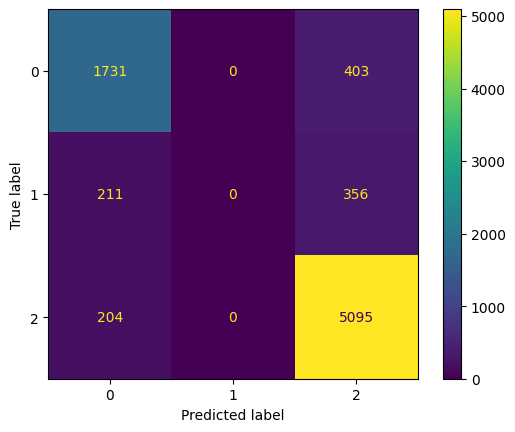

In [41]:
model = create_RNN(max_length)
model.summary()
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.002, restore_best_weights=True),
]
history = model.fit(train_ds.cache(), epochs=20, validation_data=val_ds.cache(), callbacks=callbacks)
print(f"Test dataset accuracy: {model.evaluate(test_ds)[1]}")
get_conf_matrix(model)

### 3.2 RNN with adjusted weights and default hyperparameters

Default hyperparameters:
 - embedding_dim = 128
 - lstm_units = 16
 - optimizer = 'sgd' (stochastic gradient descent)
 - metrics = 'accuracy'

Weights:
- class 0: 1.25
- class 1: 4.70
- class 2: 0.50

Test results:
- Accuracy: 0.75
- Recall: 0.69
- F1 score: 0.64

Adjusting the weights in the model resulted in worse accuracy but overal recall and f1 score were much better, which is indicative of less biased results. Quite a lot of positive reviews were misclassified as neutral as a consequence of the weight tunning.

Train times:

10 minutes on RTX 4070 locally

10 minutes on L4 on Colab Pro

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 128, 128)          1024000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1042659 (3.98 MB)
Trainable params: 1042659 (3.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2025/2025 [==============================] - 45s 21ms/step - loss: 1.0766 - 

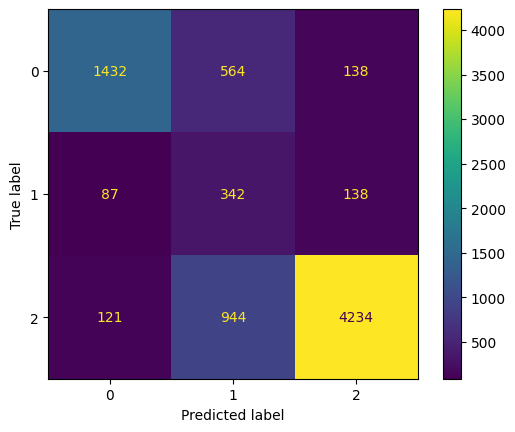

In [42]:
embedding_dim = 128
model = create_RNN(max_length, embedding_dim)
model.summary()
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.002, restore_best_weights=True),
]
history = model.fit(train_ds.cache(), epochs=20, validation_data=val_ds.cache(), callbacks=callbacks, class_weight=class_weight)
print(f"Test dataset accuracy: {model.evaluate(test_ds)[1]}")
get_conf_matrix(model)

### 3.2. RNN - tuned hyperparameters

Search space:
 -  embedding dimension: {64, 128, 256}
 -  lstm units count: {16, 32, 64}
 - optimization algorithm: {adam, sgd, adagrad}

While this is in no way an exhaustive list of hyperparameters - we could add different activation functions, make it more granular, use different method for training etc etc, it can be easily scaleable with the function provided below.

The function returns the best-performing model along with its hyperparameters based on validation accuracy. Including weights should reduce the bias in using accuracy.

Weights:
- class 0: 1.25
- class 1: 4.70
- class 2: 0.50

The best hyperparameters found:

{'optimizer': 'adam', 'lstm_units': 32, 'embedding_dim': 128}

Test results for best model:
- Accuracy: 0.79
- Recall: 0.66
- F1 score: 0.64

This model performed very much the same as the default model with adjusted weights, increasing the accuracy only so slightly. Perhaps wider search space could find significantly better set of hyperparameters.

Train times:

4.5 hours on RTX 4070 locally

2 hours on A100 on Colab Pro

In [17]:
def grid_search_RNN(epochs=20, patience=3):
    best_model = None
    best_accuracy = 0.0
    print(f"Need to train {len(param_grid_RNN['embedding_dim'])*len(param_grid_RNN['embedding_dim'])*len(param_grid_RNN['optimizer'])} RNNs.")
    count = 0
    best_hyperparams = {}
    for embedding_dim in param_grid_RNN['embedding_dim']:
        for lstm_unit in param_grid_RNN['lstm_units']:
            for optimizer in param_grid_RNN['optimizer']:
                print(f"Training model for:\n embedding_dim = {embedding_dim}\n lstm_units = {lstm_unit}\n optimizer = {optimizer}")
                model = create_RNN(max_length=max_length,
                                   embedding_dim=embedding_dim,
                                   lstm_units = lstm_unit,
                                   optimizer=optimizer)

                callbacks = [
                    keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
                ]

                history = model.fit(train_ds.cache(), epochs=epochs,
                                    validation_data=val_ds.cache(),
                                    callbacks=callbacks,
                                    class_weight=class_weight)

                val_acc = history.history['val_accuracy'][-1]
                count+=1
                print(f"{count}/{len(param_grid_RNN['embedding_dim'])*len(param_grid_RNN['embedding_dim'])*len(param_grid_RNN['optimizer'])}")
                if val_acc > best_accuracy:
                    best_model = model
                    best_accuracy = val_acc
                    best_hyperparams['optimizer'] = optimizer
                    best_hyperparams['lstm_units'] = lstm_unit
                    best_hyperparams['embedding_dim'] = embedding_dim
    return best_model, best_accuracy, best_hyperparams

param_grid_RNN = {
    'embedding_dim': [64, 128, 256],
    'lstm_units': [16, 32, 64],
    'optimizer': ['adam', 'sgd', 'adagrad'],
}

In [ ]:
best_RNN, acc_RNN, best_RNN_hyperparams = grid_search_RNN()

Best val accuracy: 0.8001388907432556
250/250 [==============================] - 2s 6ms/step - loss: 0.6587 - accuracy: 0.7935
Test dataset accuracy: 0.7935000061988831
250/250 [==============================] - 2s 5ms/step
Recall score: 0.6568568784579413
F1 score: 0.6380830783933233


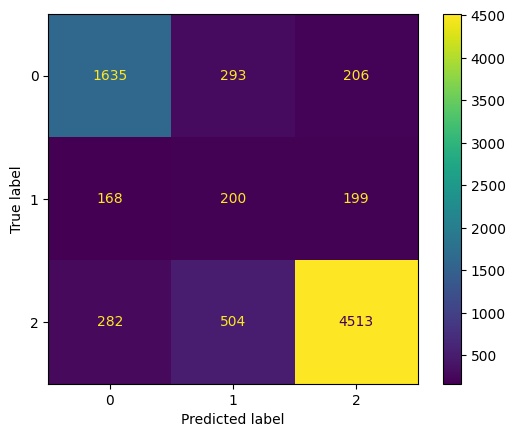

In [19]:
print(f"Best val accuracy: {acc_RNN}")
print(f"Test dataset accuracy: {best_RNN.evaluate(test_ds)[1]}")
get_conf_matrix(best_RNN)

In [26]:
best_RNN_hyperparams

{'optimizer': 'adam', 'lstm_units': 32, 'embedding_dim': 128}

## 4. Convolutional Neural Network
- train model with basic parameters
- train model with basic parameters + adjusted weights
- implement hyperparameter tuning using TFDF

While making the architecture of the Convolutional Neural Network, I experimented with adding multiple 1DConv layers. The sweet spot for computational complexity and performance was

Architecture:
1. Input layer
2. Embedding layer
3. Convolutional layer with 128 filters and kernel size 5, relu activation
4. Pooling layer, pool size 2
5. Convolutional layer with 64 filters and kernel size 4, relu activation
6. Pooling layer, pool size 2
7. Convolutional layer with 32 filters and kernel size 4, relu activation
8. Pooling layer, pool size 2
9. Hidden dense layer with 10 neurons, sigmoid activation
10. Dropout layer
11. Flatten layer
12. Output layer, 3 neurons


Total of 1147887 parameters.


### 4.1 CNN with default weights and default hyperparameters

Default hyperparameters:
 - embedding_dim = 128
 - dropout rate = 0.5
 - optimizer = 'sgd' (stochastic gradient descent)
 - activation = 'relu'

Test results:
- Accuracy: 0.84
- Recall: 0.56
- F1 score: 0.56

Model with default hyperparameters and default weights performed really well in terms of accuracy as could be expected, but poorly with Recall and F1 score. In the confusion matrix we can see that, once again, no neutral instances were identified.


Train times:

10 minutes on RTX 4070 locally

3 minutes on A100 on Colab Pro

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 128)]             0         
                                                                 
 embedding_27 (Embedding)    (None, 128, 128)          1024000   
                                                                 
 conv1d (Conv1D)             (None, 124, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1  (None, 62, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 31, 64)            0         
 g1D)                                                     

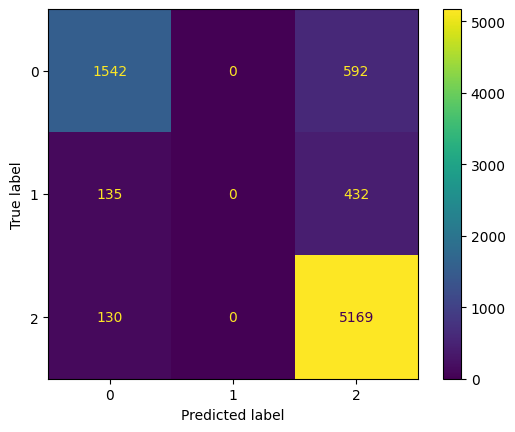

In [20]:
model = create_CNN(max_length)
model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.002, restore_best_weights=True),
]

history = model.fit(train_ds.cache(), epochs=20, validation_data=val_ds.cache(), callbacks=callbacks)
model.evaluate(test_ds)
print(f"Test dataset accuracy: {model.evaluate(test_ds)[1]}")
get_conf_matrix(model)

### 4.2 CNN with adjusted weights and default hyperparameters

Default hyperparameters:
 - embedding_dim = 128
 - dropout rate = 0.5
 - optimizer = 'sgd' (stochastic gradient descent)
 - activation = 'relu'


Weights:
- class 0: 1.25
- class 1: 4.70
- class 2: 0.50


Test results:
- Accuracy: 0.75
- Recall: 0.62
- F1 score: 0.59

Adjusting the weights once again helped with bias, while impacting the accuracy. As we can see, quite a lot of instances were misclassified as neutral while being negative.

Train times:

10 minutes on RTX 4070 locally

3 minutes on A100 on Colab Pro

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 128)]             0         
                                                                 
 embedding_28 (Embedding)    (None, 128, 128)          1024000   
                                                                 
 conv1d_3 (Conv1D)           (None, 124, 128)          82048     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 62, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 62, 64)            32832     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 31, 64)            0         
 g1D)                                                     

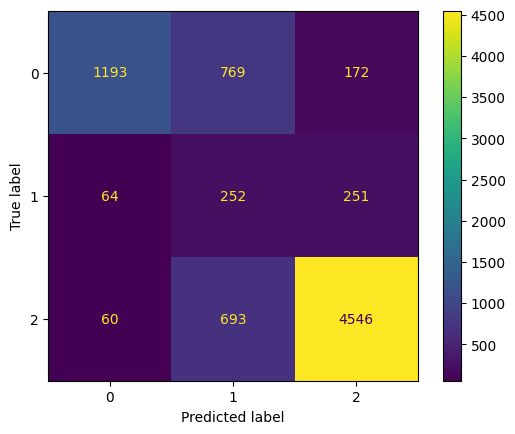

In [21]:
model = create_CNN(max_length)
model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.002, restore_best_weights=True),
]

history = model.fit(train_ds.cache(), epochs=20, validation_data=val_ds.cache(), callbacks=callbacks, class_weight=class_weight)
model.evaluate(test_ds)
print(f"Test dataset accuracy: {model.evaluate(test_ds)[1]}")
get_conf_matrix(model)

### 4.3 CNN with CUSTOM weights and default hyperparameters

Default hyperparameters:
 - embedding_dim = 128
 - dropout rate = 0.5
 - optimizer = 'sgd' (stochastic gradient descent)
 - activation = 'relu'


Weights:
- class 0: 2
- class 1: 5
- class 2: 1


Test results:
- Accuracy: 0.82
- Recall: 0.63
- F1 score: 0.63

For this model i tried manually tweaking the weights to try to find the sweet spot between variance and bias. While, once again, majority of neutral occurences were misclassified, it yielded, in my opinion, better results in terms of accuracy, recall and F1 score.

Train times:

10 minutes on RTX 4070 locally

3 minutes on A100 on Colab Pro

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 128)]             0         
                                                                 
 embedding_29 (Embedding)    (None, 128, 128)          1024000   
                                                                 
 conv1d_6 (Conv1D)           (None, 124, 128)          82048     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 62, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 62, 64)            32832     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 31, 64)            0         
 g1D)                                                     

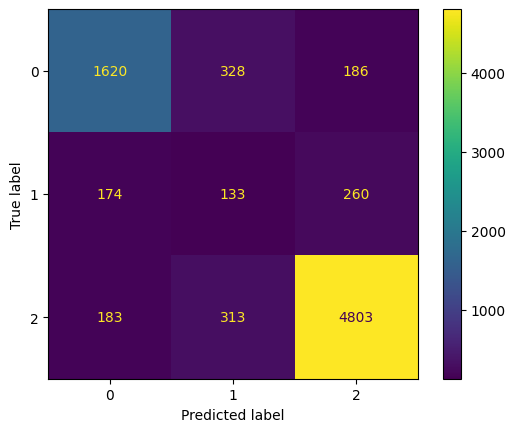

In [22]:
model = create_CNN(max_length)
model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.002, restore_best_weights=True),
]

history = model.fit(train_ds.cache(), epochs=20, validation_data=val_ds.cache(), callbacks=callbacks, class_weight={0:2,1:5,2:1})
model.evaluate(test_ds)
print(f"Test dataset accuracy: {model.evaluate(test_ds)[1]}")
get_conf_matrix(model)

### 4.4 RNN - tuned hyperparameters

Search space:
 -  embedding dimension: {64, 128, 256}
 -  dropout rate: {0.2, 0.3, 0.5}
 - optimization algorithm: {adam, sgd, adagrad}

While this is in no way an exhaustive list of hyperparameters - we could add different activation functions, make it more granular, use different method for training etc etc, it can be easily scaleable with the function provided below.

The function returns the best-performing model along with its hyperparameters based on validation accuracy. Including weights should reduce the bias in using accuracy.

Weights:
- class 0: 1.25
- class 1: 4.70
- class 2: 0.50

The best hyperparameters found:

{'optimizer': 'adam', 'dropout_rate': 0.2, 'embedding_dim': 64}

Test results for best model:
- Accuracy: 0.80
- Recall: 0.65
- F1 score: 0.64

The best model from the grid search performed better than the default model with calculated weights in all metrics and better than the default model with custom weights in terms of Recall and F1 Score. Perhaps if the custom weights were used for this training instead, we could've achieved better results.

Train times:

2 hours on RTX 4070 locally

1 hour on A100 on Colab Pro

In [23]:
def grid_search_CNN(epochs=20, patience=3):
    best_model = None
    best_accuracy = 0.0
    count = 0
    best_hyperparams = {}
    for embedding_dim in param_grid_CNN['embedding_dim']:
        for dropout_rate in param_grid_CNN['dropout_rate']:
            for optimizer in param_grid_CNN['optimizer']:
                model = create_CNN(max_length=max_length,
                                   embedding_dim=embedding_dim,
                                   dropout_rate=dropout_rate,
                                   optimizer=optimizer)

                callbacks = [
                    keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
                ]

                history = model.fit(train_ds.cache(), epochs=epochs,
                                    validation_data=val_ds.cache(),
                                    callbacks=callbacks,
                                    class_weight=class_weight)

                val_acc = history.history['val_accuracy'][-1] 
                count+=1
                print(f"{count}/{len(param_grid_CNN['embedding_dim'])*len(param_grid_CNN['embedding_dim'])*len(param_grid_CNN['optimizer'])}")
                if val_acc > best_accuracy:
                    best_model = model
                    best_accuracy = val_acc
                    best_hyperparams['optimizer'] = optimizer
                    best_hyperparams['dropout_rate'] = dropout_rate
                    best_hyperparams['embedding_dim'] = embedding_dim
    return best_model, best_accuracy, best_hyperparams


param_grid_CNN = {
    'embedding_dim': [64, 128, 256],
    'dropout_rate': [0.2, 0.3, 0.5],
    'optimizer': ['adam', 'sgd', 'adagrad']
}

In [ ]:
best_CNN, acc_CNN, best_CNN_hyperparams = grid_search_CNN()

Best val accuracy: 0.8137500286102295
250/250 [==============================] - 1s 2ms/step - loss: 0.6232 - accuracy: 0.8052
Test dataset accuracy: 0.8052499890327454
250/250 [==============================] - 1s 2ms/step
Recall score: 0.6472402478309923
F1 score: 0.6376571411945108


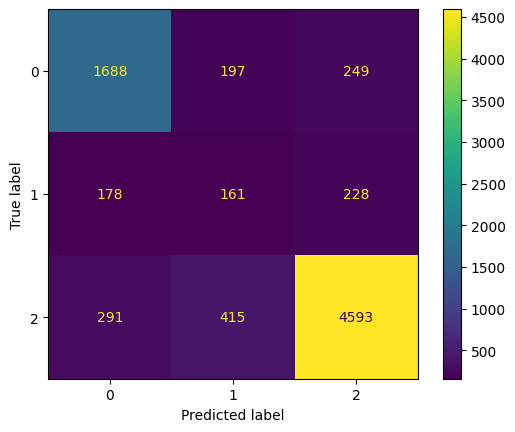

In [25]:
print(f"Best val accuracy: {acc_CNN}")
print(f"Test dataset accuracy: {best_CNN.evaluate(test_ds)[1]}")
get_conf_matrix(best_CNN)

In [27]:
best_CNN_hyperparams

{'optimizer': 'adam', 'dropout_rate': 0.2, 'embedding_dim': 64}

## Conclusion

To answer the question of what the best model is, we have to ask what the right business case for this model is. The dataset showed, that only a slight portion of reviews is actually neutral and even if there were much more many neutral class instances, it is questionable what the right use of the information in those reviews is.

If this model was to serve as a sort of way for companies to gain feedback about stenghts or weaknesses of products, then it would make sense to pick models which achieve high accuracy, even though they sacrifice some bias in the process and completely omit the neutral class. It would honestly make sense to merge neutral cases to negative or delete them it the observations altogether to create a sort of gap between 1,2 and 4,5 star reviews. In this case the best model would be the RNN with default parameters and default weights. This model could further be improved by applying the gridsearch function on it.

In the case of correct classification of all classes was of utmost importance, either the CNN or RNN with adjusted weights and tuned hyperparamters could be of use, although we tend to doubt usefulness of such solution.




### Souvislost s jinými semestrálními, případně kvalifikačními, pracemi zpracovávanými v minulosti nebo souběžně
Tato semestrální práce nemá textový ani věcný překryv, ani jinou věcnou souvislost, s jinými semestrálními nebo kvalifikačními pracemi, které jsem zpracovával/a.